# Vector and Raster Analysis

In this project, we will automate the task of creating a mosaic-ed image for a particular area of interest from a large number of image tiles. We will use as our area of interst a polygon representing Mount Desert Island in the state of Maine. We will access that geometry and identify which imagery tiles intersect the boundary. We will then clip the images to the boundary and then finally mosaic the clipped images to a new single image file.

First, let's import all the modules that we need for this project.

In [3]:
import geopandas as gpd
import rasterio.merge
import rasterio.mask
import matplotlib.pyplot as plt
from rasterio.plot import show
import os

Now we're going to read in the shapefile for our area of interest ("mdi.shp") and the shapefile that stores the image tiles boundaries ("boundaries.shp"). Let's also check the coordinate reference system for each file to make sure they are the same.

In [4]:
mdi = gpd.read_file('./data/mdi.shp')
tiles = gpd.read_file('./tiles/boundaries/boundaries.shp')
print(mdi.crs, tiles.crs)


epsg:3857 epsg:3857


Now we're going to plot the area of interest and the tile boundaries so we can see to what extent they intersect.

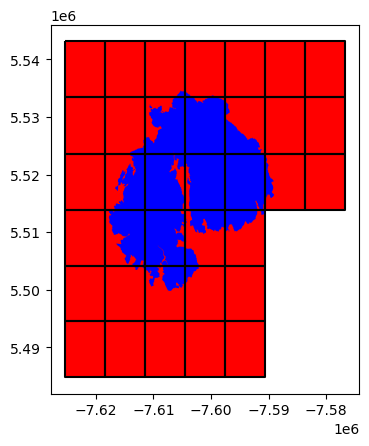

In [4]:
f, ax = plt.subplots()
tiles.exterior.plot(ax=ax, color='black')
tiles.plot(ax=ax, color='red')
mdi.plot(ax=ax, color='blue')
plt.show()

So it looks like there are several tiles that don't actually intersect our area of interest. 

The next step is to extract only those tiles that intersect our area of interest. To do this, we need the geometry of our area of interest. We can get that from the first feature in our dataset. Then we test the tiles to see if they intersect with the geometry. Then we extract only those tiles that do intersect.

In [5]:
mdi_geom = mdi.loc[0, 'geometry']
intersect_mask = tiles.intersects(mdi_geom)
intersects = tiles.loc[intersect_mask].copy()
intersects

,file_name,geometry
2,m_4406837_se_19_1_20150711_20151103.jp2,"POLYGON ((-7618430.624 5533400.133, -7611467.6..."
4,m_4406838_ne_19_1_20150706_20151103.jp2,"POLYGON ((-7604515.434 5543150.478, -7597552.4..."
5,m_4406838_nw_19_1_20150711_20151103.jp2,"POLYGON ((-7611473.309 5543150.784, -7604509.3..."
6,m_4406838_se_19_1_20150706_20151103.jp2,"POLYGON ((-7604515.899 5533400.025, -7597552.8..."
7,m_4406838_sw_19_1_20150711_20151103.jp2,"POLYGON ((-7611473.762 5533400.938, -7604509.7..."
11,m_4406839_sw_19_1_20150706_20151103.jp2,"POLYGON ((-7597558.034 5533400.988, -7590594.0..."
14,m_4406845_ne_19_1_20150711_20151103.jp2,"POLYGON ((-7618430.992 5523661.020, -7611467.9..."
16,m_4406845_se_19_1_20150711_20151103.jp2,"POLYGON ((-7618430.891 5513933.181, -7611467.8..."
18,m_4406846_ne_19_1_20150716_20151103.jp2,"POLYGON ((-7604515.673 5523661.900, -7597552.6..."
19,m_4406846_nw_19_1_20150711_20151103.jp2,"POLYGON ((-7611473.135 5523661.815, -7604509.1..."


Now, let's plot the area of interest with the intersecting tiles.

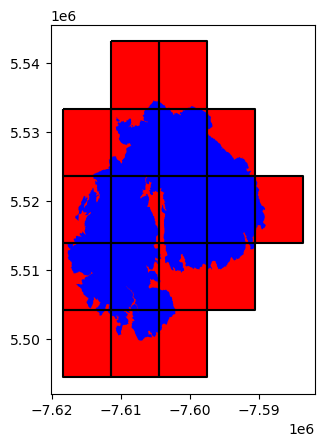

In [6]:
f, ax = plt.subplots()
intersects.exterior.plot(ax=ax, color='black')
intersects.plot(ax=ax, color='red')
mdi.plot(ax=ax, color='blue')
plt.show()

Everything looks good. Gone are the tiles that don't intersect the area of interest. Now let's print the number of intersecting tiles.

In [7]:
print(len(intersects.values))

18


Now we're going to iterate through the intersects rows, then clip the raster images to the area of interest geometry and then save each clipped image to a new file.

In [16]:
for index, tile in intersects.iterrows():

    print(f'processing index {index}')
    
    in_file_name = tile['file_name']
    in_file_path = f'./tiles/img/{in_file_name}'
    out_file_path = './tiles/clipped/' + 'clipped_' + in_file_name.split('.')[0] + '.tif'
 
    with rasterio.open(in_file_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, [mdi_geom], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
        with rasterio.open(out_file_path, "w", **out_meta) as dest:
            dest.write(out_image)

processing index 2
processing index 4
processing index 5
processing index 6
processing index 7
processing index 11
processing index 14
processing index 16
processing index 18
processing index 19
processing index 20
processing index 21
processing index 22
processing index 23
processing index 24
processing index 26
processing index 30
processing index 31


The last step is to mosaic all the clipped images into a new file. The resulting file will be quite large.

In [9]:
def filter(file):
    if file.split('.')[1] == 'tif':
        return f'./tiles/clipped/{file}'

files = os.listdir('./tiles/clipped')
tif_files = list(map(filter, files))
output_file_path = './tiles/mosaic/mosaic.tif'
rasterio.merge.merge(tif_files, dst_path=output_file_path)